## plot Figure 2 

In [38]:
#%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab
from scipy import stats
import pandas as pd 
import seaborn as sns

import sys
import os
from os import path
import glob

import cmaps
from matplotlib.ticker import MaxNLocator

font = {'family'     : 'sans-serif',
        'style'      : 'normal',
        'weight'     : 'normal',
        'size'	     : 14}
mpl.rc('font', **font)

In [35]:
def get_regional_mean(dsvar, lat_bounds=[-90, 90], lon_bounds=[0, 360]):

    # Make sure lat and lon ranges are in correct order
    if lat_bounds[0] > lat_bounds[1]:
        lat_bounds = np.flipud(lat_bounds)
    if lon_bounds[0] > lon_bounds[1]:
        lon_bounds = np.flipud(lon_bounds)
    if float(dsvar.lon.min().values) < 0.:
        raise ValueError('Not expecting longitude values less than 0.')

    dsvar_subset = dsvar.sel(lat=slice(lat_bounds[0], lat_bounds[1]),
                             lon=slice(lon_bounds[0], lon_bounds[1]))

    w = np.cos(np.deg2rad(dsvar_subset.lat))
    w = w.broadcast_like(dsvar_subset)
    x = (dsvar_subset*w).mean(dim=['lat', 'lon']) / w.mean(dim=['lat', 'lon'])

    return x

In [36]:
def get_Watanabe(sst):
    """
    WP: 110°E - 180, 5°S-5°N; 
    EP: 180-80°W, 5°S - 5°N
    """
    sst_wp = get_regional_mean(sst, lat_bounds=[-5, 5], lon_bounds=[110, 180])
    sst_ep = get_regional_mean(sst, lat_bounds=[-5, 5], lon_bounds=[180, 280])
    
    return sst_wp - sst_ep

In [37]:
def get_Dong(sst):
    """
    WP: 30°S-30°N, 50°E-160°W
    relative to the tropical mean 
    """
    sst_wp = get_regional_mean(sst, lat_bounds=[-30, 30], lon_bounds=[50, 200])
    sst_tropic = get_regional_mean(sst, lat_bounds=[-30, 30]) 
    return sst_wp/sst_tropic

In [22]:
def get_WP(sst):
    """
    WP: 30°S-30°N, 50°E-160°W
    """
    sst_wp = get_regional_mean(sst, lat_bounds=[-30, 30], lon_bounds=[50, 200])
    return sst_wp

In [23]:
def get_Vecchi(slp):
    """
    For SLP 
    EP: 160°W-80°W, 5°S-5°N 
    WP: 80°E-160°E, 5°S-5°N
    """
    slp_ep = get_regional_mean(slp, lat_bounds=[-5, 5], lon_bounds=[200, 280])/100
    slp_wp = get_regional_mean(slp, lat_bounds=[-5, 5], lon_bounds=[80, 160])/100
    return slp_ep - slp_wp

In [11]:
def get_SEP(sst):
    """
    SEP: 140°W-70°W, 65°S-45°S
    """
    sst_sep = get_regional_mean(sst, lat_bounds=[-65, -45], lon_bounds=[220, 290])
    return sst_sep

In [12]:
def get_SWP(sst):
    """
    SWP near SPCZ: 40°–30°S, 190°–210°E
    """
    sst_swp = get_regional_mean(sst, lat_bounds=[-40, -30], lon_bounds=[190, 210]) # updated 
    return sst_swp

In [14]:
def get_SO(sst):
    """
    Southern Ocean: 45°S - 75°S
    """
    sst_SO = get_regional_mean(sst, lat_bounds=[-75, -45]) # updated 
    return sst_SO

## load observations 

In [24]:
def get_obs_SST_list(ds,method):
    if method == "Watanabe":
        obs_er   = get_Watanabe(ds.ERSST5_SST)
        obs_amip = get_Watanabe(ds.AMIPII_SST)
        obs_cobe = get_Watanabe(ds.COBE_SST)
    elif method == "Dong": 
        obs_er   = get_Dong(ds.ERSST5_SST)
        obs_amip = get_Dong(ds.AMIPII_SST)
        obs_cobe = get_Dong(ds.COBE_SST)
    elif method == "SEP":
        obs_er  = get_SEP(ds.ERSST5_SST)
        obs_amip = get_SEP(ds.AMIPII_SST)
        obs_cobe = get_SEP(ds.COBE_SST)
    elif method == "WP":
        obs_er  = get_WP(ds.ERSST5_SST)
        obs_amip = get_WP(ds.AMIPII_SST)
        obs_cobe = get_WP(ds.COBE_SST)
    elif method == "SWP":
        obs_er  = get_SWP(ds.ERSST5_SST)
        obs_amip = get_SWP(ds.AMIPII_SST)
        obs_cobe = get_SWP(ds.COBE_SST)
    elif method == "SO":
        obs_er  = get_SO(ds.ERSST5_SST)
        obs_amip = get_SO(ds.AMIPII_SST)
        obs_cobe = get_SO(ds.COBE_SST)
    
    obs_all = []
    obs_all.append(obs_er)
    obs_all.append(obs_amip)
    obs_all.append(obs_cobe)

    return obs_all

In [25]:
# ## load observation
basedir = '/skdat0/dongy24/MMLEA/'
ncf = basedir + "observation_tos_1979-2020_Amean_trends.nc"
ds = xr.open_dataset(ncf)

SST_obs = ds.ERSST5_SST

obs_wata_all = get_obs_SST_list(ds,"Watanabe")
obs_dong_all = get_obs_SST_list(ds,"Dong")
obs_sep_all  = get_obs_SST_list(ds,"SEP")
obs_swp_all  = get_obs_SST_list(ds,"SWP")
obs_wp_all   = get_obs_SST_list(ds,"WP")
obs_so_all   = get_obs_SST_list(ds,"SO")

ncf = basedir + "observation_psl_1979-2020_Amean_trends.nc"
ds = xr.open_dataset(ncf)
obs_era  = get_Vecchi(ds.ERA5_PSL)
obs_jar = get_Vecchi(ds.JRA55_PSL)
obs_vecchi_all = []
obs_vecchi_all.append(obs_era)
obs_vecchi_all.append(obs_jar)

## load models

In [26]:
def get_model_list(files,method):
    model_list = []
    for f in files:
        ds = xr.open_dataset(f)
        nens = len(ds.ensemble)
        the_model = np.zeros((nens,1))
        for i in np.arange(nens):
            sst = ds.SST.isel(ensemble = i)
            slp = ds.SLP.isel(ensemble = i)
            if method == "Watanabe": 
                the_model[i] = get_Watanabe(sst).values
            elif method == "Dong": 
                the_model[i] = get_Dong(ds.SST.isel(ensemble = i)).values
            elif method == "Vecchi":
                the_model[i] = get_Vecchi(slp).values
            elif method == "SEP":
                the_model[i] = get_SEP(sst).values
            elif method == "SWP":
                the_model[i] = get_SWP(sst).values
            elif method == "WP":
                the_model[i] = get_WP(sst).values
            elif method == "SO":
                the_model[i] = get_SO(sst).values    
        model_list.append(the_model)
    return model_list

In [27]:
# ## load model SST trend patterns
models = []
models.append('ACCESS')
models.append('CanESM2')
models.append('CanESM5')
models.append('CESM1')
models.append('CESM2')
models.append('CNRM-CM6')
models.append('CSIRO-MK36')
models.append('EC-Earth3')
models.append('GFDL-CM3')
models.append('GFDL-ESM2M')
models.append('GISS-E21G')
models.append('IPSL-CM6A')
models.append('MIROC6')
models.append('MIROC-ES2L')
models.append('MPI')
models.append('NorCPM1')


In [28]:
files = []
for m in models:
    f = basedir + m + "_tos_psl_1979-2020_Amean_trends.nc"
    files.append(f)

In [29]:
model_wata_all   =  get_model_list(files,"Watanabe")
model_dong_all   =  get_model_list(files,"Dong")
model_vecchi_all =  get_model_list(files,"Vecchi")
model_sep_all    =  get_model_list(files,"SEP")
model_swp_all    =  get_model_list(files,"SWP")
model_wp_all     =  get_model_list(files,"WP")
model_so_all     =  get_model_list(files,"SO")


In [30]:
# check ensemble size for each model 
for m,kk in zip(models,model_wata_all):
    print(m + ": " + str(len(kk)))

ACCESS: 13
CanESM2: 50
CanESM5: 25
CESM1: 40
CESM2: 99
CNRM-CM6: 10
CSIRO-MK36: 30
EC-Earth3: 50
GFDL-CM3: 20
GFDL-ESM2M: 30
GISS-E21G: 10
IPSL-CM6A: 11
MIROC6: 50
MIROC-ES2L: 30
MPI: 100
NorCPM1: 30


In [31]:
# load trends of the calcualated leading patterns 

file = basedir + "Robb_mat_data/tk1_tk2_trends_16model_multivariate_ERSST5_ERA5_1979-2020_Amean_80deg_5yr_N20_S2N_all_obs.mat"

data = sio.loadmat(file)
#data.keys()

mnumber = data['model_number'].transpose((1,0))
tk1 = data['tk1_trends'].transpose((1,0))
tk2 = data['tk2_trends'].transpose((1,0))

obs_tk1 = data["tk1_obs_trends"]
obs_tk2 = data["tk2_obs_trends"]

model_tk1_all = []
model_tk2_all = []

for i in np.arange(1,len(models)+1):
    x = tk1[mnumber == i]
    model_tk1_all.append(x)
    y = tk2[mnumber == i]
    model_tk2_all.append(y)
    


## Make violin plot

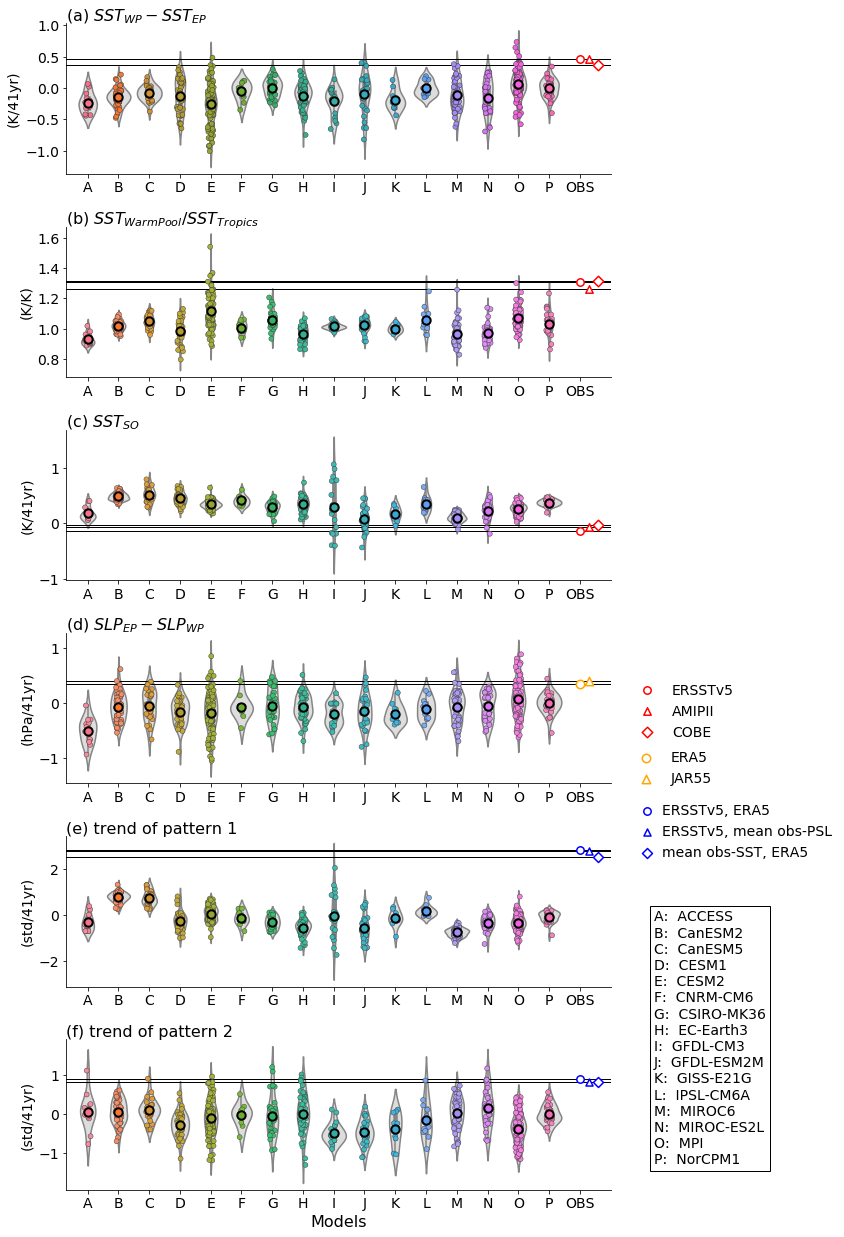

In [32]:
fig, axes = plt.subplots(6,1,figsize=(12,18)) #sharex=True
axes = axes.ravel()

markers = ["o","^","D"]
labels = ["ERSSTv5","AMIPII","COBE","ERA5","JAR55"]
labels_mix = ["ERSSTv5, ERA5","ERSSTv5, mean obs-PSL","mean obs-SST, ERA5"]

cmap = sns.color_palette("husl", 16)

ax = axes[0]
ax.text(0,1.02,"(a) $SST_{WP} - SST_{EP}$", transform = ax.transAxes,fontsize = 16)
ax.set_ylabel('(K/41yr)', fontsize = 14)
sns.violinplot(data = model_wata_all,lw=2,ax = ax,color='#DDDDDD') #color='#DDDDDD'
sns.stripplot(data=model_wata_all,jitter=True,linewidth=.5, ax = ax,palette = cmap)
# add ensemble-mean 
for i in np.arange(16):
    data_mean = model_wata_all[i].mean()
    ax.scatter(i,data_mean,s = 70,edgecolor = "k",lw = 2,facecolor = cmap[i],zorder = 5)
# add obs-mean    
for i in np.arange(3):
    obs = obs_wata_all[i].values
    ax.axhline(obs,color = "k",linestyle = "-",lw = 1)
    ax.scatter(16 + i * 0.3,obs,s = 55, marker = markers[i],edgecolor = "r", lw = 1.5,color = 'w',zorder=3)

ax = axes[1]
ax.text(0,1.02,"(b) $SST_{Warm Pool}/SST_{Tropics}$", transform = ax.transAxes,fontsize = 16)
ax.set_ylabel('(K/K)',fontsize = 14)
sns.violinplot(data=model_dong_all, lw=2,ax = ax,color='#DDDDDD') #color='#DDDDDD'
sns.stripplot(data=model_dong_all,jitter=True, linewidth=.5, ax = ax)
# add ensemble-mean 
for i in np.arange(16):
    data_mean = model_dong_all[i].mean()
    ax.scatter(i,data_mean,s = 70,edgecolor = "k",lw = 2,facecolor = cmap[i],zorder = 5)
for i in np.arange(3):
    obs = obs_dong_all[i].values
    ax.axhline(obs,color = "k",linestyle = "-",lw = 1)
    ax.scatter(16 + i * 0.3,obs,s = 55, marker = markers[i],edgecolor = "r", lw = 1.5,color = 'w',zorder=3,label = labels[i])

ax = axes[2]
ax.text(0,1.02,"(c) $SST_{SO}$", transform = ax.transAxes,fontsize = 16)
ax.set_ylabel('(K/41yr)',fontsize = 14)
sns.violinplot(data=model_so_all, lw=2,ax = ax,color='#DDDDDD') #color='#DDDDDD'
sns.stripplot(data=model_so_all,jitter=True, linewidth=.5, ax = ax)
# add ensemble-mean 
for i in np.arange(16):
    data_mean = model_so_all[i].mean()
    ax.scatter(i,data_mean,s = 70,edgecolor = "k",lw = 2,facecolor = cmap[i],zorder = 5)
for i in np.arange(3):
    obs = obs_so_all[i].values
    ax.axhline(obs,color = "k",linestyle = "-",lw = 1)
    ax.scatter(16 + i * 0.3,obs,s = 55, marker = markers[i],edgecolor = "r", lw = 1.5,color = 'w',zorder=3,label = labels[i])
ax.legend(bbox_to_anchor=(1.25, -.6),frameon = False)
#ax.set_ylim([-1,2])

ax = axes[3]
ax.text(0,1.02,"(d) $SLP_{EP} - SLP_{WP}$", transform = ax.transAxes,fontsize = 16)
ax.set_ylabel('(hPa/41yr)',fontsize = 14)
sns.violinplot(data=model_vecchi_all, lw=2,ax = ax,color='#DDDDDD') #color='#DDDDDD'
sns.stripplot(data=model_vecchi_all,jitter=True, linewidth=.5, ax = ax)
# add ensemble-mean 
for i in np.arange(16):
    data_mean = model_vecchi_all[i].mean()
    ax.scatter(i,data_mean,s = 70,edgecolor = "k",lw = 2,facecolor = cmap[i],zorder = 5)
for i in np.arange(2): # SLP obs
    obs = obs_vecchi_all[i].values
    ax.axhline(obs,color = "k",linestyle = "-",lw = 1)
    ax.scatter(16 + i * 0.3,obs,s = 70, marker = markers[i],edgecolor = "orange", lw = 1.5,color = 'w',zorder=3,label = labels[i+3])
ax.legend(bbox_to_anchor=(1.21, .3),frameon = False)

ax = axes[4]
ax.text(0,1.02,"(e) trend of pattern 1", transform = ax.transAxes,fontsize = 16)
ax.set_ylabel('(std/41yr)',fontsize = 14)
sns.violinplot(data=model_tk1_all, lw=2,ax = ax,color='#DDDDDD') #color='#DDDDDD'
sns.stripplot(data=model_tk1_all,jitter=True, linewidth=.5, ax = ax)
for i in np.arange(16):
    data_mean = model_tk1_all[i].mean()
    ax.scatter(i,data_mean,s = 70,edgecolor = "k",lw = 2,facecolor = cmap[i],zorder = 5)
ax.axhline(obs_tk1[0,0],lw = 1, color = "k")
ax.axhline(np.mean(obs_tk1[0,:]),lw = 1, color = "k") # ERSST5 vs SLP mean 
ax.axhline(np.mean(obs_tk1[:,0]),lw = 1,color = "k") # SST mean vs ERA5
ax.scatter(16,obs_tk1[0,0],s = 55, marker = markers[0],edgecolor = "b", lw = 1.5,color = 'w',zorder=3,label = labels_mix[0])
ax.scatter(16+1*0.3,np.mean(obs_tk1[0,:]),s = 50, marker = markers[1],edgecolor = "b", lw = 1.5,color = 'w',zorder=3,label = labels_mix[1])
ax.scatter(16+2*0.3,np.mean(obs_tk1[:,0]),s = 50, marker = markers[2],edgecolor = "b", lw = 1.5,color = 'w',zorder=3,label = labels_mix[2])
ax.legend(bbox_to_anchor=(1.43, 1.3),handletextpad=0.1,frameon = False)

ax = axes[5]
ax.text(0,1.02,"(f) trend of pattern 2", transform = ax.transAxes,fontsize = 16)
ax.set_ylabel('(std/41yr)',fontsize = 14)
sns.violinplot(data=model_tk2_all, lw=2,ax = ax,color='#DDDDDD') #color='#DDDDDD'
sns.stripplot(data=model_tk2_all,jitter=True, linewidth=.5, ax = ax)
#ax.axhline(np.nanmean(obs_tk2),c = "k",linestyle = "--",lw = 2)
for i in np.arange(16):
    data_mean = model_tk2_all[i].mean()
    ax.scatter(i,data_mean,s = 70,edgecolor = "k",lw = 2,facecolor = cmap[i],zorder = 5)
    
ax.axhline(obs_tk2[0,0],lw = 1, color = "k")
ax.axhline(np.mean(obs_tk2[0,:]),lw = 1, color = "k") # ERSST5 vs SLP mean 
ax.axhline(np.mean(obs_tk2[:,0]),lw = 1,color = "k") # SST mean vs ERA5
ax.scatter(16,obs_tk2[0,0],s = 55, marker = markers[0],edgecolor = "b", lw = 1.5,color = 'w',zorder=3)
ax.scatter(16 + 1 * 0.3,np.mean(obs_tk2[0,:]),s = 50, marker = markers[1],edgecolor = "b", lw = 1.5,color = 'w',zorder=3)
ax.scatter(16 + 2 * 0.3,np.mean(obs_tk2[:,0]),s = 50, marker = markers[2],edgecolor = "b", lw = 1.5,color = 'w',zorder=3)

ax.set_xlabel("Models",fontsize = 16)

ml = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","OBS"]

for ax in axes: 
    ax.set_xticks(np.arange(0, len(models) + 1))
    ax.set_xlim([-.7,17])
    ax.set_xticklabels(ml)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.plot()

# for i in np.arange(16):
#     plt.gcf().text(0.8, 0.6-i*.02, ml[i] + ": " + models[i], fontsize=14) 

text = "\n".join(["A:  "+models[0], "B:  "+models[1],  "C:  "+models[2],  "D:  "+models[3],
                  "E:  "+models[4], "F:  "+models[5],  "G:  "+models[6],  "H:  "+models[7],
                  "I:  "+models[8], "J:  "+models[9],  "K:  "+models[10], "L:  "+models[11],
                  "M:  "+models[12],"N:  "+models[13], "O:  "+models[14], "P:  "+models[15]])

props = dict(facecolor='none')
plt.gcf().text(0.78, 0.07, text, fontsize=14,bbox=props)  

#plt.tight_layout()
fig.subplots_adjust(bottom=0.05, top=0.95, left=0.1, right=0.73,
                    wspace=0.2, hspace=0.35)

#plt.savefig("Fig2.eps",format='eps')


## Make supplementary figure

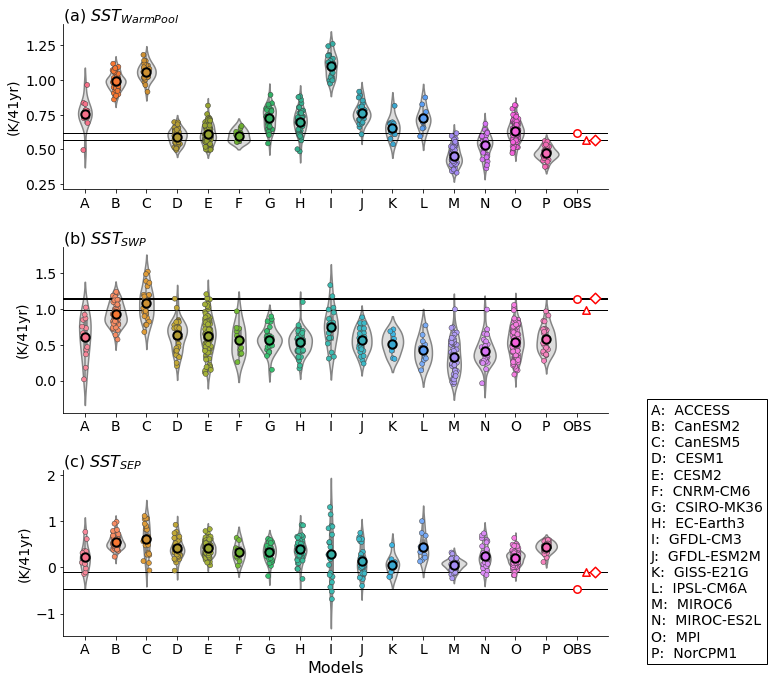

In [33]:
# ----- seaborn -----
fig, axes = plt.subplots(3,1,figsize=(12,10)) #sharex=True
axes = axes.ravel()

markers = ["o","^","D"]
labels = ["ERSSTv5","AMIPII","COBE","ERA5","JAR55"]
labels_mix = ["ERSSTv5, ERA5","ERSSTv5, mean obs-PSL","mean obs-SST, ERA5"]

cmap = sns.color_palette("husl", 16)

ax = axes[0]
ax.text(0,1.02,"(a) $SST_{WarmPool}$", transform = ax.transAxes,fontsize = 16)
ax.set_ylabel('(K/41yr)', fontsize = 14)
sns.violinplot(data = model_wp_all,lw=2,ax = ax,color='#DDDDDD') #color='#DDDDDD'
sns.stripplot(data=model_wp_all,jitter=True,linewidth=.5, ax = ax,palette = cmap)
# add ensemble-mean 
for i in np.arange(16):
    data_mean = model_wp_all[i].mean()
    ax.scatter(i,data_mean,s = 70,edgecolor = "k",lw = 2,facecolor = cmap[i],zorder = 5)
# add obs-mean    
for i in np.arange(3):
    obs = obs_wp_all[i].values
    ax.axhline(obs,color = "k",linestyle = "-",lw = 1)
    ax.scatter(16 + i * 0.3,obs,s = 55, marker = markers[i],edgecolor = "r", lw = 1.5,color = 'w',zorder=3)

ax = axes[1]
ax.text(0,1.02,"(b) $SST_{SWP}$", transform = ax.transAxes,fontsize = 16)
ax.set_ylabel('(K/41yr)',fontsize = 14)
sns.violinplot(data=model_swp_all, lw=2,ax = ax,color='#DDDDDD') #color='#DDDDDD'
sns.stripplot(data=model_swp_all,jitter=True, linewidth=.5, ax = ax)
# add ensemble-mean 
for i in np.arange(16):
    data_mean = model_swp_all[i].mean()
    ax.scatter(i,data_mean,s = 70,edgecolor = "k",lw = 2,facecolor = cmap[i],zorder = 5)
for i in np.arange(3):
    obs = obs_swp_all[i].values
    ax.axhline(obs,color = "k",linestyle = "-",lw = 1)
    ax.scatter(16 + i * 0.3,obs,s = 55, marker = markers[i],edgecolor = "r", lw = 1.5,color = 'w',zorder=3,label = labels[i])

ax = axes[2]
ax.text(0,1.02,"(c) $SST_{SEP}$", transform = ax.transAxes,fontsize = 16)
ax.set_ylabel('(K/41yr)',fontsize = 14)
sns.violinplot(data=model_sep_all, lw=2,ax = ax,color='#DDDDDD') #color='#DDDDDD'
sns.stripplot(data=model_sep_all,jitter=True, linewidth=.5, ax = ax)
# add ensemble-mean 
for i in np.arange(16):
    data_mean = model_sep_all[i].mean()
    ax.scatter(i,data_mean,s = 70,edgecolor = "k",lw = 2,facecolor = cmap[i],zorder = 5)
for i in np.arange(3):
    obs = obs_sep_all[i].values
    ax.axhline(obs,color = "k",linestyle = "-",lw = 1)
    ax.scatter(16 + i * 0.3,obs,s = 55, marker = markers[i],edgecolor = "r", lw = 1.5,color = 'w',zorder=3,label = labels[i])
    
ax.set_xlabel("Models",fontsize = 16)

ml = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","OBS"]

for ax in axes: 
    ax.set_xticks(np.arange(0, len(models) + 1))
    ax.set_xlim([-.7,17])
    ax.set_xticklabels(ml)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.plot()

# for i in np.arange(16):
#     plt.gcf().text(0.8, 0.6-i*.02, ml[i] + ": " + models[i], fontsize=14) 

text = "\n".join(["A:  "+models[0], "B:  "+models[1],  "C:  "+models[2],  "D:  "+models[3],
                  "E:  "+models[4], "F:  "+models[5],  "G:  "+models[6],  "H:  "+models[7],
                  "I:  "+models[8], "J:  "+models[9],  "K:  "+models[10], "L:  "+models[11],
                  "M:  "+models[12],"N:  "+models[13], "O:  "+models[14], "P:  "+models[15]])

props = dict(facecolor='none')
plt.gcf().text(0.78, 0.07, text, fontsize=14,bbox=props)  

#plt.tight_layout()
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.73,
                    wspace=0.2, hspace=0.35)


#plt.savefig(spath+ "Fig2_supplement.eps",format='eps')
